In [8]:
from statsmodels.tsa.stattools import acf as sm_acf, pacf_yw
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SOAL 1

In [3]:
import pandas as pd

# filename: make_timeseries_dataframe.py

def make_timeseries_df(start_date="2024-01-01", freq="W"):
    # Data dari tabel (gunakan '.' sebagai pemisah ribuan)
    weeks = list(range(1, 16))
    visitors_str = [
        "820","890","870","950","1.020","980","1.050","1.080",
        "1.150","1.100","1.030","950","900","900","800"
    ]
    visitors = [int(x.replace(".", "")) for x in visitors_str]

    # Buat indeks waktu mingguan
    dates = pd.date_range(start=start_date, periods=len(weeks), freq=freq)

    # DataFrame siap untuk analisis time-series
    df = pd.DataFrame(
        {"t": weeks, "visitors": visitors},
        index=dates
    )
    df.index.name = "date"  # indeks datetime untuk time series
    return df

if __name__ == "__main__":
    ts_df = make_timeseries_df()
    print(ts_df)

             t  visitors
date                    
2024-01-07   1       820
2024-01-14   2       890
2024-01-21   3       870
2024-01-28   4       950
2024-02-04   5      1020
2024-02-11   6       980
2024-02-18   7      1050
2024-02-25   8      1080
2024-03-03   9      1150
2024-03-10  10      1100
2024-03-17  11      1030
2024-03-24  12       950
2024-03-31  13       900
2024-04-07  14       900
2024-04-14  15       800


In [5]:
df=ts_df.copy()

In [6]:
df.describe()

,t,visitors
count,15.000000,15.000000
mean,8.000000,966.000000
std,4.472136,104.252441
min,1.000000,800.000000
25%,4.500000,895.000000
50%,8.000000,950.000000
75%,11.500000,1040.000000
max,15.000000,1150.000000


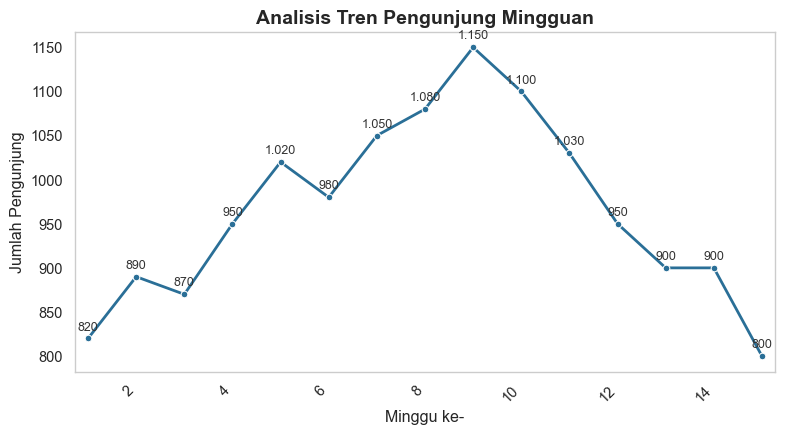

In [19]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
fig, ax = plt.subplots(figsize=(8, 4.5))
sns.lineplot(data=df, x='t', y='visitors', marker='o', linewidth=2, color='#2a6f97', ax=ax)

for x, y in zip(df['t'], df['visitors']):
    ax.annotate(f'{y:,}'.replace(',', '.'), xy=(x, y), xytext=(0, 6),
                textcoords='offset points', ha='center', fontsize=9, color='#333333')

ax.set_title('Analisis Tren Pengunjung Mingguan', fontsize=14, fontweight='bold')
ax.set_xlabel('Minggu ke-')
ax.set_ylabel('Jumlah Pengunjung')
plt.xticks(rotation=45, ha='right')
ax.margins(x=0.02)
plt.grid(False)
plt.tight_layout()

In [20]:
# 1) n, mean, sample variance
n = len(df)
zbar = df['visitors'].mean()
s2 = df['visitors'].var(ddof=1)  # sample variance
print(f"n = {n}, mean = {zbar}, sample variance = {s2}")

n = 15, mean = 966.0, sample variance = 10868.57142857143


In [21]:
# 2) First difference
diff1 = df['visitors'].diff()

In [23]:
df_s = pd.DataFrame({'t': df['t'], 'visitors': df['visitors'], 'diff1': diff1})
df_s

,t,visitors,diff1
date,,,
2024-01-07,1,820,NaN
2024-01-14,2,890,70.0
2024-01-21,3,870,-20.0
2024-01-28,4,950,80.0
2024-02-04,5,1020,70.0
2024-02-11,6,980,-40.0
2024-02-18,7,1050,70.0
2024-02-25,8,1080,30.0
2024-03-03,9,1150,70.0


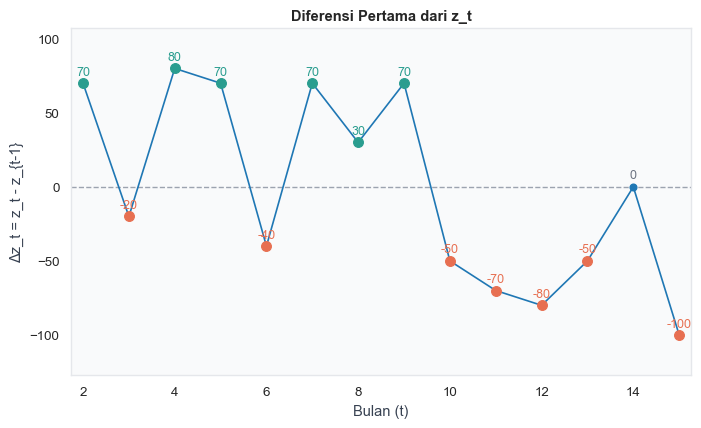

In [29]:
# Make the plot more appealing and add data labels via a draw callback
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.1)
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#f9fafb',
    'axes.edgecolor': '#e5e7eb',
    'axes.titleweight': 'bold',
    'axes.labelcolor': '#374151',
})

fig, _ax_local = plt.subplots(figsize=(8, 4.5))

def _enhance_plot(event):
    ax_local = event.canvas.figure.axes[0]
    if getattr(ax_local, '_enhanced', False):
        return
    # Zero reference line
    ax_local.axhline(0, color='#9ca3af', lw=1, ls='--', zorder=1)
    # Overlay colored points (pos/neg)
    s = df_s['diff1']
    t = df_s['t']
    pos = s > 0
    neg = s < 0
    ax_local.scatter(t[pos], s[pos], color='#2a9d8f', s=50, zorder=3)
    ax_local.scatter(t[neg], s[neg], color='#e76f51', s=50, zorder=3)
    # Data labels
    for x_i, y_i in zip(t, s):
        if pd.isna(y_i):
            continue
        c = '#2a9d8f' if y_i > 0 else ('#e76f51' if y_i < 0 else '#6b7280')
        ax_local.annotate(f'{y_i:.0f}', (x_i, y_i), textcoords='offset points',
                          xytext=(0, 6), ha='center', fontsize=9, color=c)
    ax_local.margins(x=0.02, y=0.15)
    ax_local._enhanced = True

fig.canvas.mpl_connect('draw_event', _enhance_plot)
plt.sca(_ax_local)
plt.plot(df_s['t'], df_s['diff1'], marker='o')
plt.title('Diferensi Pertama dari z_t')
plt.xlabel('Bulan (t)')
plt.ylabel('Δz_t = z_t - z_{t-1}')
plt.grid(False)
plt.show()

In [30]:
# 3) Deviations from mean (z_t - zbar)
dev_from_mean = df_s['visitors'] - zbar

# Buat DataFrame ringkasan
df = pd.DataFrame({
    't': df_s['t'],
    'z_t': df_s['visitors'],
    'Δz_t (first diff)': diff1.values,
    'z_t - z̄ (deviasi)': dev_from_mean.values
})

In [31]:
df

,t,z_t,Δz_t (first diff),z_t - z̄ (deviasi)
date,,,,
2024-01-07,1,820,NaN,-146.0
2024-01-14,2,890,70.0,-76.0
2024-01-21,3,870,-20.0,-96.0
2024-01-28,4,950,80.0,-16.0
2024-02-04,5,1020,70.0,54.0
2024-02-11,6,980,-40.0,14.0
2024-02-18,7,1050,70.0,84.0
2024-02-25,8,1080,30.0,114.0
2024-03-03,9,1150,70.0,184.0


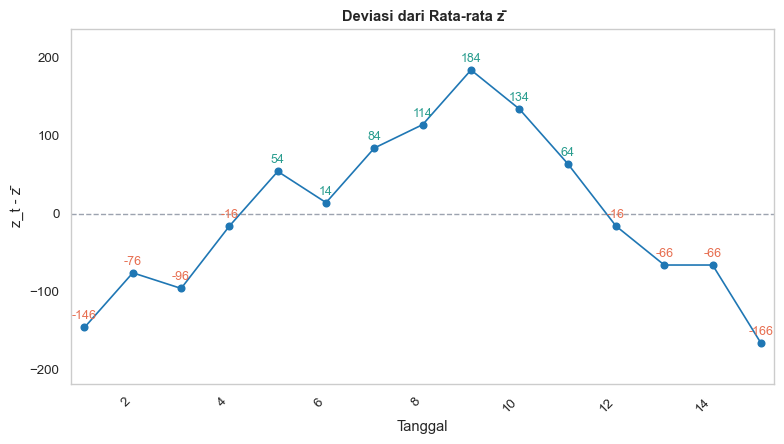

In [35]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.1)

fig2, ax2 = plt.subplots(figsize=(8, 4.5))
ax2.axhline(0, color='#9ca3af', lw=1, ls='--', zorder=1)

# Data labels with sign-based colors
for x_i, y_i in zip(df['t'], df['z_t - z̄ (deviasi)']):
    c = '#2a9d8f' if y_i > 0 else ('#e76f51' if y_i < 0 else '#6b7280')
    ax2.annotate(f'{y_i:.0f}', (x_i, y_i), textcoords='offset points',
                 xytext=(0, 6), ha='center', fontsize=9, color=c)

ax2.set_xlabel('Tanggal')
ax2.set_ylabel('z_t - z̄')
plt.xticks(rotation=45, ha='right')
ax2.margins(x=0.02, y=0.15)
plt.tight_layout()
plt.plot(df['t'], df['z_t - z̄ (deviasi)'], marker='o')
plt.title('Deviasi dari Rata-rata z̄')
plt.grid(False)

# SOAL 2

In [36]:
df = pd.DataFrame({
    't': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'zt': [25, 26, 25, 27, 28, 27.5, 29, 30, 31, 30.5, 29.5, 28.5]
})

In [38]:
zbar = df['zt'].mean()
df['z̄']= zbar
df['z̄t']=df['zt'] - df['z̄']
df['z̄t+1']=df['z̄t'].shift(-1)
df

,t,zt,z̄,z̄t,z̄t+1
0,1,25.0,28.083333,-3.083333,-2.083333
1,2,26.0,28.083333,-2.083333,-3.083333
2,3,25.0,28.083333,-3.083333,-1.083333
3,4,27.0,28.083333,-1.083333,-0.083333
4,5,28.0,28.083333,-0.083333,-0.583333
5,6,27.5,28.083333,-0.583333,0.916667
6,7,29.0,28.083333,0.916667,1.916667
7,8,30.0,28.083333,1.916667,2.916667
8,9,31.0,28.083333,2.916667,2.416667
9,10,30.5,28.083333,2.416667,1.416667


In [39]:
df['z̄t*z̄t+1']=df['z̄t'] * df['z̄t+1']
df['z̄t^2']=df['z̄t'] **2
df

,t,zt,z̄,z̄t,z̄t+1,z̄t*z̄t+1,z̄t^2
0,1,25.0,28.083333,-3.083333,-2.083333,6.423611,9.506944
1,2,26.0,28.083333,-2.083333,-3.083333,6.423611,4.340278
2,3,25.0,28.083333,-3.083333,-1.083333,3.340278,9.506944
3,4,27.0,28.083333,-1.083333,-0.083333,0.090278,1.173611
4,5,28.0,28.083333,-0.083333,-0.583333,0.048611,0.006944
5,6,27.5,28.083333,-0.583333,0.916667,-0.534722,0.340278
6,7,29.0,28.083333,0.916667,1.916667,1.756944,0.840278
7,8,30.0,28.083333,1.916667,2.916667,5.590278,3.673611
8,9,31.0,28.083333,2.916667,2.416667,7.048611,8.506944
9,10,30.5,28.083333,2.416667,1.416667,3.423611,5.840278


In [40]:
r1 = df['z̄t*z̄t+1'].sum() / df['z̄t^2'].sum()
r1

0.7448578342407743

In [41]:
# Convert 't' (1..12) to monthly datetimes in 2025 without specifying a day
df['t'] = pd.to_datetime('2025-' + df['t'].astype(str).str.zfill(2), format='%Y-%m')
df

,t,zt,z̄,z̄t,z̄t+1,z̄t*z̄t+1,z̄t^2
0,2025-01-01,25.0,28.083333,-3.083333,-2.083333,6.423611,9.506944
1,2025-02-01,26.0,28.083333,-2.083333,-3.083333,6.423611,4.340278
2,2025-03-01,25.0,28.083333,-3.083333,-1.083333,3.340278,9.506944
3,2025-04-01,27.0,28.083333,-1.083333,-0.083333,0.090278,1.173611
4,2025-05-01,28.0,28.083333,-0.083333,-0.583333,0.048611,0.006944
5,2025-06-01,27.5,28.083333,-0.583333,0.916667,-0.534722,0.340278
6,2025-07-01,29.0,28.083333,0.916667,1.916667,1.756944,0.840278
7,2025-08-01,30.0,28.083333,1.916667,2.916667,5.590278,3.673611
8,2025-09-01,31.0,28.083333,2.916667,2.416667,7.048611,8.506944
9,2025-10-01,30.5,28.083333,2.416667,1.416667,3.423611,5.840278


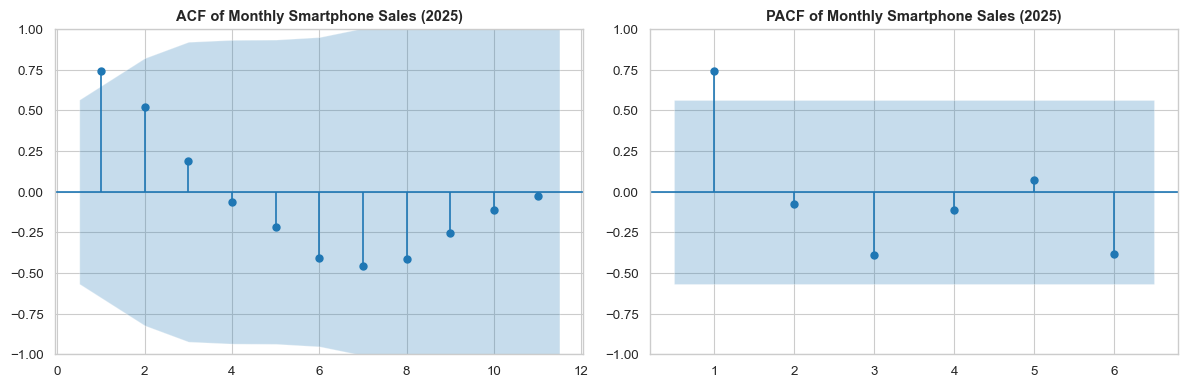

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = df.sort_values('t')['zt']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].cla()
plot_acf(series, lags=min(len(series) - 1, 12), zero=False, ax=axes[0])
axes[0].set_title('ACF of Monthly Smartphone Sales (2025)')

axes[1].cla()
plot_pacf(series, lags=min(len(series) - 1, 6), method='ywm', zero=False, ax=axes[1])
axes[1].set_title('PACF of Monthly Smartphone Sales (2025)')
plt.tight_layout()

In [51]:
from statsmodels.tsa.stattools import acf as sm_acf, pacf_yw

# Use the same lag setting as the plots (0..6)
lags = min(len(series) - 1, 6)

# Compute ACF and PACF values
acf_vals = sm_acf(series, nlags=11, fft=False)
pacf_vals = pacf_yw(series, nlags=lags, method='mle')  # matches plot_pacf(method='ywm')

# Extend PACF to lags 0..11 with NaN for lags 7..11 and rebuild the DataFrame
pacf_full = np.full(len(acf_vals), np.nan, dtype=float)
pacf_full[:len(pacf_vals)] = pacf_vals

acf_pacf_df = pd.DataFrame({
    'lag': np.arange(len(acf_vals)),
    'acf': acf_vals,
    'pacf': pacf_full
})
acf_pacf_df

,lag,acf,pacf
0,0,1.000000,1.000000
1,1,0.744858,0.744858
2,2,0.520569,-0.076922
3,3,0.187387,-0.390674
4,4,-0.065033,-0.111495
5,5,-0.214005,0.069482
6,6,-0.409256,-0.380080
7,7,-0.457502,NaN
8,8,-0.410466,NaN
9,9,-0.254537,NaN


In [57]:
sr1=1*(len(series)**(-1/2)) # standard error
t_r1= acf_pacf_df.loc[1, 'acf'] / sr1
t_r1

2.5802632266414762

In [58]:
sr1

0.28867513459481287

In [61]:
# Add t-statistics for ACF and PACF (approx t = value * sqrt(n), for lags > 0)
n = len(series)
sqrt_n = np.sqrt(n)
mask0 = acf_pacf_df['lag'] == 0

acf_pacf_df['acf_t'] = acf_pacf_df['acf'] * sqrt_n
acf_pacf_df.loc[mask0, 'acf_t'] = np.nan

acf_pacf_df['pacf_t'] = acf_pacf_df['pacf'] * sqrt_n
acf_pacf_df.loc[mask0, 'pacf_t'] = np.nan

acf_pacf_df

,lag,acf,pacf,acf_se,acf_t,pacf_se,pacf_t
0,0,1.000000,1.000000,NaN,NaN,NaN,NaN
1,1,0.744858,0.744858,0.258199,2.580263,0.258199,2.580263
2,2,0.520569,-0.076922,0.375022,1.803303,0.258199,-0.266465
3,3,0.187387,-0.390674,0.420445,0.649126,0.258199,-1.353334
4,4,-0.065033,-0.111495,0.425976,-0.225282,0.258199,-0.386230
5,5,-0.214005,0.069482,0.426638,-0.741335,0.258199,0.240692
6,6,-0.409256,-0.380080,0.433735,-1.417704,0.258199,-1.316637
7,7,-0.457502,NaN,0.458757,-1.584832,NaN,NaN
8,8,-0.410466,NaN,0.488227,-1.421895,NaN,NaN
9,9,-0.254537,NaN,0.510715,-0.881743,NaN,NaN


In [62]:
# Fix acf_t using: se_k = sqrt((1 + 2 * sum_{j=1}^{k-1} r_j^2) / n),  t_k = r_k / se_k  for k >= 1
r = acf_pacf_df['acf'].to_numpy()
K = len(r) - 1

cum_sq = np.cumsum(r[1:]**2)                      # r1^2, r2^2, ...
S = np.concatenate(([0.0], cum_sq[:-1])) if K > 0 else np.array([], dtype=float)  # sum_{j=1}^{k-1} r_j^2

acf_se = np.full(len(r), np.nan, dtype=float)
if K > 0:
    acf_se[1:] = np.sqrt((1.0 + 2.0 * S) / n)

acf_t_fixed = np.full(len(r), np.nan, dtype=float)
if K > 0:
    acf_t_fixed[1:] = r[1:] / acf_se[1:]

acf_pacf_df['acf_se'] = acf_se
acf_pacf_df['acf_t'] = acf_t_fixed

acf_pacf_df

,lag,acf,pacf,acf_se,acf_t,pacf_se,pacf_t
0,0,1.000000,1.000000,NaN,NaN,NaN,NaN
1,1,0.744858,0.744858,0.288675,2.580263,0.258199,2.580263
2,2,0.520569,-0.076922,0.419288,1.241555,0.258199,-0.266465
3,3,0.187387,-0.390674,0.470072,0.398634,0.258199,-1.353334
4,4,-0.065033,-0.111495,0.476256,-0.136551,0.258199,-0.386230
5,5,-0.214005,0.069482,0.476995,-0.448652,0.258199,0.240692
6,6,-0.409256,-0.380080,0.484931,-0.843947,0.258199,-1.316637
7,7,-0.457502,NaN,0.512906,-0.891979,NaN,NaN
8,8,-0.410466,NaN,0.545855,-0.751969,NaN,NaN
9,9,-0.254537,NaN,0.570997,-0.445777,NaN,NaN


In [63]:
# Fix pacf_t using se(phi_k) ≈ 1/sqrt(n) for k ≥ 1 (white-noise null)
sqrt_n = np.sqrt(n)
se_const = 1.0 / sqrt_n  # sqrt_n already available

mask = (acf_pacf_df['lag'] > 0) & acf_pacf_df['pacf'].notna()

pacf_se = np.full(len(acf_pacf_df), np.nan, dtype=float)
pacf_se[mask] = se_const

pacf_t_fixed = np.full(len(acf_pacf_df), np.nan, dtype=float)
pacf_t_fixed[mask] = acf_pacf_df.loc[mask, 'pacf'].to_numpy() / se_const

acf_pacf_df['pacf_se'] = pacf_se
acf_pacf_df['pacf_t'] = pacf_t_fixed

acf_pacf_df

,lag,acf,pacf,acf_se,acf_t,pacf_se,pacf_t
0,0,1.000000,1.000000,NaN,NaN,NaN,NaN
1,1,0.744858,0.744858,0.288675,2.580263,0.288675,2.580263
2,2,0.520569,-0.076922,0.419288,1.241555,0.288675,-0.266465
3,3,0.187387,-0.390674,0.470072,0.398634,0.288675,-1.353334
4,4,-0.065033,-0.111495,0.476256,-0.136551,0.288675,-0.386230
5,5,-0.214005,0.069482,0.476995,-0.448652,0.288675,0.240692
6,6,-0.409256,-0.380080,0.484931,-0.843947,0.288675,-1.316637
7,7,-0.457502,NaN,0.512906,-0.891979,NaN,NaN
8,8,-0.410466,NaN,0.545855,-0.751969,NaN,NaN
9,9,-0.254537,NaN,0.570997,-0.445777,NaN,NaN
